# OSM Amenity Map

In [27]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely.geometry
import geopandas as gpd

import mapclassify as mc
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, to_hex

In [2]:
#filepath = "/home/nikolai/data/naturalearth/ne_10m_admin_1_states_provinces.shp"
filepath = "/home/nikolai/data/naturalearth/ne_10m_admin_0_countries.shp"

gdf = gpd.read_file(filepath)
gdf.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."


In [113]:
filepath = "data/europe-amenity-features.csv.gz"

df = pd.read_csv(filepath, index_col='nuts_id')
df.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
nuts_id,,,,,,,,,,,,,,,,,,,,,
AL,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013
AL0,0.000605,0.0004,0.000323,0.000749,0.000343,0.000018,0.000475,0.00002,0.00063,0.000145,...,0.0001,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013


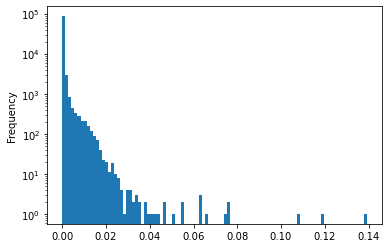

In [114]:
pd.Series(df.values.flatten()).plot(kind='hist', bins=100, logy=True);

In [115]:
#color_list = ['#24262E', '#00D2D4', '#FF972A']
#color_list = ['#00D2D4', '#FF972A']
color_list = ['#00D2D4', '#E8FFFF', '#FF972A']

cmap = LinearSegmentedColormap.from_list(
    "custom_gradient", color_list)

In [118]:
colors = [to_hex(cm.viridis(t)) for t in np.linspace(0, 1, 7)]
colors

['#440154', '#443983', '#31688e', '#21918c', '#35b779', '#90d743', '#fde725']

In [119]:
gdf_nuts = gpd.read_file("data/nuts_60m.gpkg")
mask = gdf_nuts['levl_code'] == 2
nuts_ids = gdf_nuts[mask]['nuts_id'].values

In [120]:
mask = df.index.isin(nuts_ids)
df = df[mask]

In [121]:
nb = mc.NaturalBreaks(1000 * df.fillna(0).values.flatten(), k=7)
nb

NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.53] | 15929
( 0.53,  1.95] |  1975
( 1.95,  4.79] |   322
( 4.79,  9.12] |   148
( 9.12, 14.81] |    99
(14.81, 30.48] |    24
(30.48, 62.91] |     3

In [126]:
properties = ['restaurant', 'parking', 'cafe', 'bank', 'atm', 'fast_food', 'fuel', 'school', 'police']

data = {
    'bins': {},
    'colors': colors,
    'properties': properties
}
for prop in properties:
    values = df[prop].dropna().values
    #m = mc.NaturalBreaks(values, k=7)
    m = mc.Quantiles(values, k=7)
    data['bins'][prop] = m.bins.tolist()

In [127]:
with open("website/data/nuts2_amenity_bins.json", "w") as f:
    json.dump(data, f)

In [97]:
gdf_tmp = gdf_nuts.set_index('nuts_id')[['geometry']] \
  .join(df['parking']).dropna(subset='parking') \
  .to_crs(epsg=3035)

In [102]:
m = mc.Quantiles(gdf_tmp['parking'].values, k=7)
m

Quantiles           

  Interval     Count
--------------------
[0.00, 0.00] |    47
(0.00, 0.00] |    46
(0.00, 0.01] |    47
(0.01, 0.01] |    46
(0.01, 0.01] |    47
(0.01, 0.01] |    46
(0.01, 0.06] |    47

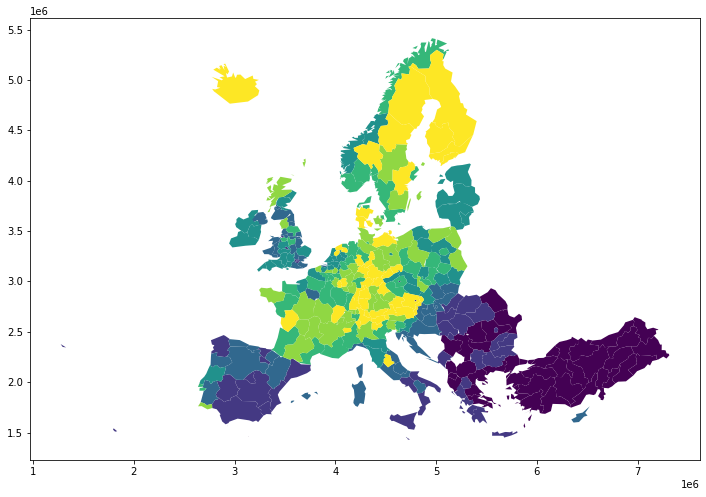

In [112]:
fig, ax = plt.subplots(figsize=(12, 10))

for i in range(7):
    mask = m.yb == i
    gdf_tmp[mask].plot(ax=ax, color=colors[i]);

In [130]:
gdf_testing = gpd.read_file("website/data/nuts2_data_simplified.json")
gdf_testing.head(2)

,restaurant,parking,cafe,bank,atm,fast_food,fuel,school,police,name,country,DEFR,FRUK,UKDE,nuts_id,geometry
0,0.000179,0.000018,0.000504,0.000051,0.000017,0.000102,0.000065,0.000040,0.000006,Veri,AL,0.577738,0.794598,0.007488,AL01,"MULTIPOLYGON (((19.83100 42.46645, 20.07630 42..."
1,0.000213,0.000002,0.000234,0.000068,0.000006,0.000065,0.000049,0.000025,0.000005,Qender,AL,0.759033,0.839917,0.000007,AL02,"MULTIPOLYGON (((19.90835 41.51193, 20.23617 41..."


In [131]:
properties = ['restaurant', 'parking', 'cafe', 'bank', 'atm', 'fast_food', 'fuel', 'school', 'police']

data = {
    'bins': {},
    'colors': colors,
    'properties': properties
}
for prop in properties:
    values = gdf_testing[prop].dropna().values
    #m = mc.NaturalBreaks(values, k=7)
    m = mc.Quantiles(values, k=7)
    data['bins'][prop] = m.bins.tolist()

In [132]:
with open("website/data/nuts2_amenity_bins.json", "w") as f:
    json.dump(data, f)